cord19q: COVID-19 Open Research Dataset (CORD-19) Analysis
======

![CORD19](https://pages.semanticscholar.org/hs-fs/hubfs/covid-image.png?width=300&name=covid-image.png)

***NOTE: There is a [Report Builder Notebook](https://www.kaggle.com/davidmezzetti/cord-19-report-builder) that runs on a prebuilt model. If you just want to try this out without a full build, this is the best choice. [Task Reports](#List-of-task-reports) are available in both Notebook and Excel formats.***

COVID-19 Open Research Dataset (CORD-19) is a free resource of scholarly articles, aggregated by a coalition of leading research groups, about COVID-19 and the coronavirus family of viruses. The dataset can be found on [Semantic Scholar](https://pages.semanticscholar.org/coronavirus-research) and there is a research challenge on [Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge).

This project builds an index over the CORD-19 dataset to assist with analysis and data discovery. A series of tasks were explored to identify relevant articles and help find answers to key scientific questions on a number of COVID-19 research topics. 

*An example result snippet is shown below for one of the task questions. For each task question, a highlights section is built with a summary of the results along with each matching article and each article's text matches.*

>## Effectiveness of drugs being developed and tried to treat COVID-19 patients.
>
>#### Highlights<br/>
>- Currently, there are no approved drugs to treat the infection. [Arya et al](https://doi.org/10.26434/chemrxiv.11860011.v2)<br/>
>- Antiviral drugs: lopinavir/ritonavir and ribavirin had been tried to treat SARS disease with apparent favorable clinical response. [Wu et al](https://doi.org/10.1097/jcma.0000000000000270)<br/>
>- Although antiviral drugs, including osehamivir and ribavirin had been applied to our patients, to date no effective antiviral to treat COVID-19 has been identified. [Xu et al](https://doi.org/10.1101/2020.03.03.20030668)<br/>
>
>#### Articles<br/>
>|Date|Authors|Title|LOE & Sample|Matches|
>|----|----|----|----|----|
>|2020|Wang et al|[Science in the fight against the novel coronavirus disease](https://doi.org/10.1097/cm9.0000000000000777)<br/>Chin Med J (Engl)|II. Randomized Controlled Trial<br/><br/>They performed a metagenomic analysis of respiratory tract specimens obtained from five patients suffering from the pneumonia in question and identified the virus now known as 2019-nCoV as the causative agent.|As specific therapies targeting 2019-nCoV are lacking, it may be useful to repurpose drugs already licensed for marketing or clinical trials to treat COVID-19 patients in an emergency response; researchers are actively working to identify such drugs.<br/><br/> Clinical trials are also underway to validate the effectiveness of various other licensed drugs against COVID-19.|

# Install from GitHub

![](http://)Full source code for [cord19q](https://github.com/neuml/cord19q) is on GitHub and be installed into this notebook as follows:

In [1]:
# Install cord19q project
!pip install git+https://github.com/neuml/cord19q

# Install scispacy model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz

  Cloning https://github.com/neuml/cord19q to /tmp/pip-req-build-a8touwhx
  Running command git clone -q https://github.com/neuml/cord19q /tmp/pip-req-build-a8touwhx
     |████████████████████████████████| 35.5 MB 277 kB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 1.5 MB 48.8 MB/s 
     |████████████████████████████████| 141 kB 43.2 MB/s 
  Created wheel for cord19q: filename=cord19q-1.0.0-py3-none-any.whl size=38945 sha256=a0a148c2d6d2c078f591772f70719b700c134a587ddbd33a1f3fad624b2be401
  Stored in directory: /tmp/pip-ephem-wheel-cache-g7p1st93/wheels/6d/f1/cb/14bad060a1eed2722526727216834de47c3868aa72bc016edc
  Created wheel for mdv: filename=mdv-1.7.4-py3-none-any.whl size=45303 sha256=e795412b253b6f2d2f706ba70790a66b5ac4ce269f7a2e7e69509e8d7fb4a1dd
  Stored in directory: /root/.cache/pip/wheels/63/0a/4a/aec2ce7667a209d11fe97038998f908f333bd231761d66f744
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449907

This notebook requires Internet connectivity to be enabled. If this notebook is copied, the GitHub project could also be forked for an edited notebook to modify the Python code. Would simply just need to update the pip install command above to the new repository location.

# Build SQLite articles database

The raw CORD-19 data is stored across a metadata.csv file and json files with the full text. This project uses [SQLite](https://www.sqlite.org/index.html) to aggregate and store the merged content.

The ETL process transforms the csv/json files into a SQLite database. The process iterates over each row in metadata.csv, extracts the column data and ensures it is not a pure duplicate (using the sha hash). This process will also load the full text if available. 

## Tagging
Articles are tagged based on keyword matches. The only tag at this time is COVID-19 and articles are tagged with this if the article text contains any of the following regular expressions. 

>2019[\-\s]?n\s?cov, 2019 novel coronavirus, coronavirus 2019, coronavirus disease (?:20)?19, covid(?:[\- ]19)?, n\s?cov 2019, sars-cov-2, wuhan (?:coronavirus|pneumonia)

Credit to [@ajrwhite](https://www.kaggle.com/ajrwhite) and his [notebook](https://www.kaggle.com/ajrwhite/covid-19-thematic-tagging-with-regular-expressions) in helping to develop this list.

## Study Design
Additional metadata is parsed out of the article to derive information on the study design.

### Design Type
The full text is analyzed to determine a design type for the backing study in the article. This logic is pessimistic and will assign the largest number (lowest level of confidence). The process builds a feature vector of counts for keywords in each design type category. It also has minimum count required to be considered a member of a category. Titles are also analyzed for design type matches.

Credit to [@savannareid](https://www.kaggle.com/savannareid) for developing the keywords to use with this method. The keywords can be found in this [domain dictionary](https://docs.google.com/spreadsheets/d/1t2e3CHGxHJBiFgHeW0dfwtvCG4x0CDCzcTFX7yz9Z2E/edit#gid=389064679). More details on deriving a study design can be found in [this discussion](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/139355). 

### Sample Size
Additionally, the full text is analyzed to determine the sample size for the backing study in the article. This logic uses Natural Lanuage Processing (NLP) via scispacy to find tokens that look to represent a sample. For example, for a Systematic Review, the logic looks for the word studies and determines if it has a number associated with it. That full sentence is used as the sample to give context to the sample size. This logic is also used to identify the sampling method.

### Measurements and Statistics
The NLP process identifies study measurements and statistics from the full text. Example statistics are the odds ratio of hypertension within a study, including a 95% confidence interval. scispacy has been pretrained on medical articles and has good entity detection on such articles. Using the detected entities, logic runs to find the matching statistic for a topic (such as hypertension) within a text section. The current process can currently only extract statistics, not calculate statistics from lower level data.

## Grammar Labels
The title, abstract and full-text fields are tokenized into sentences. Linguistic rules are used to label each sentence to help identify concise, data-driven statements. 

For the linguistic rules process, it has two basic rules right now.

1. *QUESTION*: Sentence ending in a '?' mark
2. *FRAGMENT*: Less informative/incomplete statements. Acceptable sentences have the following structure.
  - At least one nominal subject noun/proper noun AND
  - At least one action/verb AND
  - At least 5 words

Important source files to highlight
- ETL Process -> [execute.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/etl/execute.py)
- Study Design rules -> [design.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/etl/design.py)
- Sample Size Detection rules -> [sample.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/etl/sample.py)
- Study Stats Detection rules -> [stats.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/etl/stats.py)
- Linguistic rules -> [grammar.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/etl/grammar.py)


In [2]:
from cord19q.etl.execute import Execute as Etl

# Build SQLite database for metadata.csv and json full text files
Etl.run("../input/CORD-19-research-challenge", "cord19q")

Building articles.sqlite from ../input/CORD-19-research-challenge
Inserted 1000 articles
Inserted 2000 articles
Inserted 3000 articles
Inserted 4000 articles
Inserted 5000 articles
Inserted 6000 articles
Inserted 7000 articles
Inserted 8000 articles
Inserted 9000 articles
Inserted 10000 articles
Inserted 11000 articles
Inserted 12000 articles
Inserted 13000 articles
Inserted 14000 articles
Inserted 15000 articles
Inserted 16000 articles
Inserted 17000 articles
Inserted 18000 articles
Inserted 19000 articles
Inserted 20000 articles
Inserted 21000 articles
Inserted 22000 articles
Inserted 23000 articles
Inserted 24000 articles
Inserted 25000 articles
Inserted 26000 articles
Inserted 27000 articles
Inserted 28000 articles
Inserted 29000 articles
Inserted 30000 articles
Inserted 31000 articles
Inserted 32000 articles
Inserted 33000 articles
Inserted 34000 articles
Inserted 35000 articles
Inserted 36000 articles
Inserted 37000 articles
Inserted 38000 articles
Inserted 39000 articles
Inserte

Upon completion, a database named articles.sqlite will be stored in the output directory under a sub-folder named cord19q.

# Build Embedding Index

An embeddings index is created with [FastText](https://fasttext.cc/) + [BM25](https://en.wikipedia.org/wiki/Okapi_BM25). Background on this method can be found in this [Medium article](https://towardsdatascience.com/building-a-sentence-embedding-index-with-fasttext-and-bm25-f07e7148d240) and an existing repository using this method [codequestion](https://github.com/neuml/codequestion).

The embeddings index takes each COVID-19 tagged, not labeled a question/fragment, having a detected study type, tokenizes the text, and builds a sentence embedding. A sentence embedding is a BM25 weighted combination of the FastText vectors for each token in the sentence. The embeddings index takes the full corpus of these embeddings and builds a [Faiss](https://github.com/facebookresearch/faiss) index to enable similarity searching. 

Important source files to highlight

* Indexing Process -> [index.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/index.py)
* Tokenizer -> [tokenizer.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/tokenizer.py)
* Embeddings Model -> [embeddings.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/embeddings.py)
* BM25 Scoring -> [scoring.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/scoring.py)

FastText vectors trained on the full CORD-19 corpus are required. A [dataset with pre-trained vectors](https://www.kaggle.com/davidmezzetti/cord19-fasttext-vectors) is included and used in this notebook. Building the vectors takes a couple of hours when locally trained and would most likely take much longer within a notebook. 

Vectors can optionally be (re)built by running the following command with the project and articles.sqlite database installed locally:

```
python -m cord19q.vectors
```

The following code builds the embeddings index using fastText vectors trained on the full CORD-19 dataset. Alternatively, any [pymagnitude vector file](https://github.com/plasticityai/magnitude#pre-converted-magnitude-formats-of-popular-embeddings-models) can be used the build the sentence embeddings.

In [3]:
import shutil

from cord19q.index import Index

# Copy vectors locally for predictable performance
shutil.copy("../input/cord19-fasttext-vectors/cord19-300d.magnitude", "/tmp")

# Build the embeddings index
Index.run("cord19q", "/tmp/cord19-300d.magnitude")

Building new model
Streamed 1000 documents
Streamed 2000 documents
Streamed 3000 documents
Streamed 4000 documents
Streamed 5000 documents
Streamed 6000 documents
Streamed 7000 documents
Streamed 8000 documents
Streamed 9000 documents
Streamed 10000 documents
Streamed 11000 documents
Streamed 12000 documents
Streamed 13000 documents
Streamed 14000 documents
Streamed 15000 documents
Streamed 16000 documents
Streamed 17000 documents
Streamed 18000 documents
Streamed 19000 documents
Streamed 20000 documents
Streamed 21000 documents
Streamed 22000 documents
Streamed 23000 documents
Streamed 24000 documents
Streamed 25000 documents
Streamed 26000 documents
Streamed 27000 documents
Streamed 28000 documents
Streamed 29000 documents
Streamed 30000 documents
Streamed 31000 documents
Streamed 32000 documents
Streamed 33000 documents
Streamed 34000 documents
Streamed 35000 documents
Streamed 36000 documents
Streamed 37000 documents
Streamed 38000 documents
Streamed 39000 documents
Streamed 40000 

In [4]:
from cord19q.highlights import Highlights
from cord19q.tokenizer import Tokenizer

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import pycountry

# Tokenizes text and removes stopwords
def tokenize(text, case_sensitive=False):
    # Get list of accepted tokens
    tokens = [token for token in Tokenizer.tokenize(text) if token not in Highlights.STOP_WORDS]
    
    if case_sensitive:
        # Filter original tokens to preserve token casing
        return [token for token in text.split() if token.lower() in tokens]

    return tokens
    
# Country data
countries = [c.name for c in pycountry.countries]
countries = countries + ["USA"]

# Lookup country name for alpha code. If already an alpha code, return value
def countryname(x):
    country = pycountry.countries.get(alpha_3=x)
    return country.name if country else x
    
# Resolve alpha code for country name
def countrycode(x):
    return pycountry.countries.get(name=x).alpha_3

# Tokenize and filter only country names
def countrynames(x):
    return [countryname(country) for country in countries if country.lower() in x.lower()]

# Word Cloud colors
def wcolors(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    colors = ["#7e57c2", "#03a9f4", "#011ffd", "#ff9800", "#ff2079"]
    return np.random.choice(colors)

# Word Cloud visualization
def wordcloud(df, title = None):
    # Set random seed to have reproducible results
    np.random.seed(64)
    
    wc = WordCloud(
        background_color="white",
        max_words=200,
        max_font_size=40,
        scale=5,
        random_state=0
    ).generate_from_frequencies(df)

    wc.recolor(color_func=wcolors)
    
    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')

    if title:
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wc),
    plt.show()

# Dataframe plot
def plot(df, title, kind="bar", color="bbddf5"):
    # Remove top and right border
    ax = plt.axes()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set axis color
    ax.spines['left'].set_color("#bdbdbd")
    ax.spines['bottom'].set_color("#bdbdbd")

    df.plot(ax=ax, title=title, kind=kind, color=color);

# Pie plot
def pie(labels, sizes, title):
    patches, texts = plt.pie(sizes, colors=["#4caf50", "#ff9800", "#03a9f4", "#011ffd", "#ff2079", "#7e57c2", "#fdd835"], startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.title(title)
    plt.show()
    
# Map visualization
def mapplot(df, title, bartitle):
    fig = go.Figure(data=go.Choropleth(
        locations = df["Code"],
        z = df["Count"],
        text = df["Country"],
        colorscale = [(0,"#fffde7"), (1,"#f57f17")],
        showscale = False,
        marker_line_color="darkgray",
        marker_line_width=0.5,
        colorbar_title = bartitle,
    ))

    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        )
    )
    
    fig.show(config={"displayModeBar": False, "scrollZoom": False})

# Exploring the data
The articles database has a copy of all articles that were found in metadata.csv. Pure duplicate articles (based on the sha hash) are filtered out. In addition to the metadata and text fields, a field named tags is added. Each article is tagged based on the topic. The only tag at this time is COVID-19 for articles that directly mention COVID-19 and related terms. This field is important as the embedding index and all model searches will go against the subset of data tagged as COVID-19.

## Articles Table
A sample of the articles table is shown below.

In [5]:
import pandas as pd
import sqlite3

# Connect to database
db = sqlite3.connect("cord19q/articles.sqlite")

# Articles
pd.set_option("max_colwidth", 125)
articles = pd.read_sql_query("select * from articles where tags is not null LIMIT 5", db)
articles

,Id,Source,Published,Publication,Authors,Title,Tags,Design,Keywords,Size,Sample,Method,Reference
0,d958168df85240e544a918d843a14e887dc41d2b,PMC,2020-01-23 00:00:00,Euro Surveill,None,Note from the editors: novel coronavirus (2019-nCoV),COVID-19,0,None,None,None,None,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6988271/
1,3e039d09e97b28724f19438f21fcebab6c15c986,PMC,2020-01-31 00:00:00,Asia Pac Allergy,"Chang, Yoon-Seok",The 10th Anniversary of Asia Pacific Allergy,COVID-19,0,None,None,None,None,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7016318/
2,4b36607cdbc54f8006161a9a1839489dd0a51269,PMC,2020-02-10 00:00:00,Int Health,"Li, Hong-Ying; Zhu, Guang-Jian; Zhang, Yun-Zhi; Zhang, Li-Biao; Hagan, Emily A; Martinez, Stephanie; Chmura, Aleksei A; F...",A qualitative study of zoonotic risk factors among rural communities in southern China,COVID-19,7,"'risk factors': 9, 'followed': 2",88,"Eighty-eight individuals from community sites were enrolled in the study from nine sites in the Yunnan (n=36), Guangxi (n...","METHODS: Residents in rural communities of Yunnan, Guangxi and Guangdong provinces were recruited and enrolled in this st...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7017878/
3,a31e238ea606104be7767e9be5d639604014734d,PMC,2020-02-05 00:00:00,Int J Environ Res Public Health,"Wu, Jing; Gamber, Michelle; Sun, Wenjie",Does Wuhan Need to be in Lockdown during the Chinese Lunar New Year?,COVID-19,0,None,None,None,None,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7037444/
4,45a566c71056ba4faab425b4f7e9edee6320e4a4,PMC,2020-02-25 00:00:00,Front Cell Dev Biol,"Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian...",Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From ...,COVID-19,5,"'patients': 22, 'recruit': 2, 'subjects': 1",None,None,"Factors such as RANTES and CXCL10, which recruit immune cells to induce apoptosis, are strongly induced from IFV infected...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/


## Sections Table
In addition to the articles table, another table named sections is also created. The full text content is stored here. Each row is a single sentence from an article. Sentences are parsed using [NTLK's](https://www.nltk.org/) sent_tokenize method. The article id and tags are also stored with each section. The sections schema and sample rows are shown below.

In [6]:
# Connect to database
db = sqlite3.connect("cord19q/articles.sqlite")

# Sections
pd.set_option("max_colwidth", 125)
sections = pd.read_sql_query("select * from sections where tags is not null LIMIT 5", db)
sections

,Id,Article,Tags,Design,Name,Text,Labels
0,3255110,d958168df85240e544a918d843a14e887dc41d2b,COVID-19,0,TITLE,Note from the editors: novel coronavirus (2019-nCoV),FRAGMENT
1,3255111,d958168df85240e544a918d843a14e887dc41d2b,COVID-19,0,None,"The situation has continued to evolve rapidly since then and just a few weeks later, as at 23 January, 614 laboratory-con...",None
2,3255112,d958168df85240e544a918d843a14e887dc41d2b,COVID-19,0,None,"Meanwhile, on 7 January 2020, the novel coronavirus, currently named 2019-nCoV, was officially announced as the causative...",None
3,3255113,d958168df85240e544a918d843a14e887dc41d2b,COVID-19,0,None,"In order to support public health action, viral genome sequences were released by Chinese researchers on 10 January [4] a...",None
4,3255114,d958168df85240e544a918d843a14e887dc41d2b,COVID-19,0,None,"While more cases are being reported on a daily basis and there is evidence for some human-to-human transmission in China,...",None


## Most Frequent Words in Tagged Articles
The following wordcloud shows the most frequent words within the titles of tagged articles.

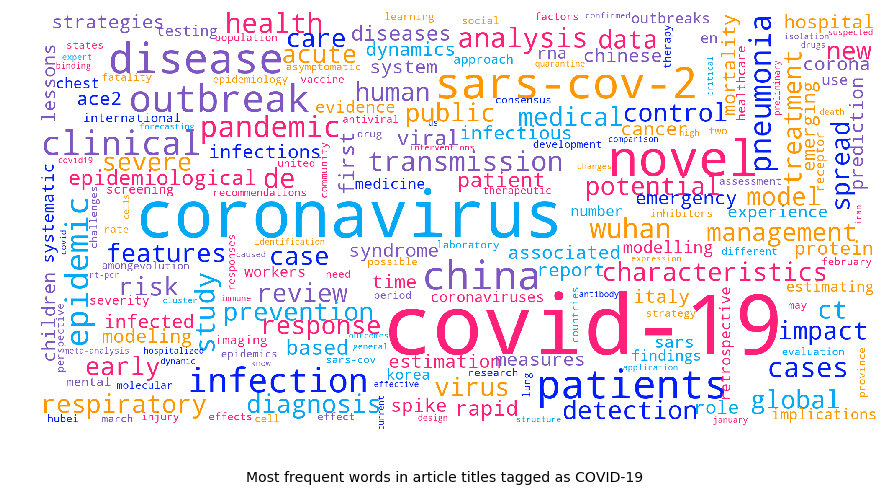

In [7]:
# Connect to database
db = sqlite3.connect("cord19q/articles.sqlite")

# Select data
articles = pd.read_sql_query("select title from articles where tags is not null", db)

# Build word frequencies on filtered tokens
freqs = pd.Series(np.concatenate([tokenize(x) for x in articles.Title])).value_counts()
wordcloud(freqs, "Most frequent words in article titles tagged as COVID-19")

## Tagged Articles by Country Mentioned
The following map shows the Articles by Country mentioned. China is mentioned significantly more and it's count is clipped in this graphic to allow showing distribution across the globe.

In [8]:
# Connect to database
db = sqlite3.connect("cord19q/articles.sqlite")

sections = pd.read_sql_query("select text from sections where tags is not null", db)

# Filter tokens to only country names. Build dataframe of Country, Count, Code
mentions = pd.Series(np.concatenate([countrynames(x) for x in sections.Text])).value_counts()
mentions = mentions.rename_axis("Country").reset_index(name="Count")
mentions["Code"] = [countrycode(x) for x in mentions["Country"]]

# Set max to 1000 to allow shading for multiple countries
mentions["Count"] = mentions["Count"].clip(upper=2500)

mapplot(mentions, "Tagged Articles by Country Mentioned", "Articles by Country")

## Tagged Articles by Source
The following graph shows the articles grouped by the source field in the metadata.

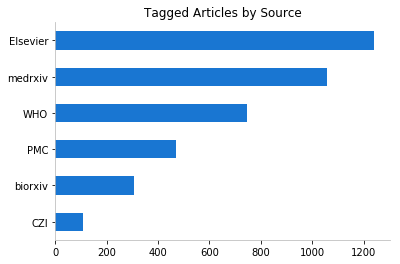

In [9]:
# Connect to database
db = sqlite3.connect("cord19q/articles.sqlite")

articles = pd.read_sql_query("select source from articles where tags is not null", db)

freqs = articles.Source.value_counts().sort_values(ascending=True)
plot(freqs, "Tagged Articles by Source", "barh", "#1976d2")

## Tagged Articles by Publication
The graph below shows the articles grouped by publication. Only the Top 20 publications are shown and many articles have no publication.

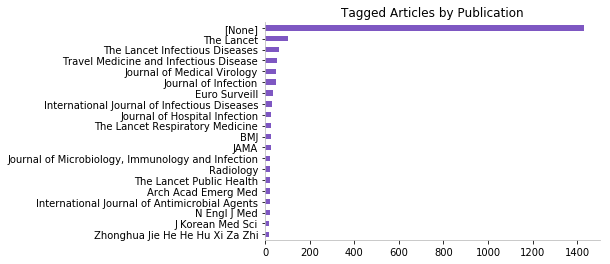

In [10]:
# Connect to database
db = sqlite3.connect("cord19q/articles.sqlite")

articles = pd.read_sql_query("select case when (Publication = '' OR Publication IS NULL) THEN '[None]' ELSE Publication END AS Publication from articles where tags is not null", db)

freqs = articles.Publication.value_counts().sort_values(ascending=True)[-20:]

plot(freqs, "Tagged Articles by Publication", "barh", "#7e57c2")

## Tagged Articles by Publication Month
The following graph shows articles by publication month. All of the articles have a publication date of 2020 or later (or the date is null). Many publication dates only include the year but there is a significant portion of articles this month, which shows the rapid pace things are moving. Also note that some publication dates are in the future. The articles have been released early to help find answers.

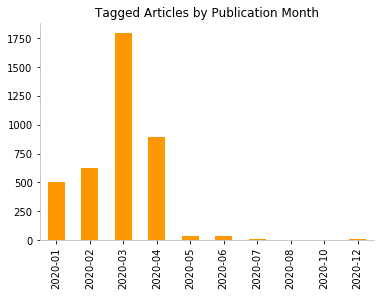

In [11]:
# Connect to database
db = sqlite3.connect("cord19q/articles.sqlite")

articles = pd.read_sql_query("select strftime('%Y-%m', published) as Published from articles where tags is not null and published >= '2020-01-01' order by published", db)

freqs = articles.Published.value_counts().sort_index()
plot(freqs, "Tagged Articles by Publication Month", "bar", "#ff9800")

## Tagged Articles by Study Design
The chart below shows articles grouped by study design type. The study design gives researchers insight into the overall structure and quality of a study. The more rigor and hard data that goes into a study, the more reliable. This is a distinction compared to many other search systems, where we look for the best matching text. Credibility of the information is very important 
in helping judge whether the conclusions are reliable. 

The medical field is rightfully a skeptical field. Many technologists are accustomed to running a web search and quickly trying the top results until you get to something that works. Lets be glad our doctors don't do the same. 

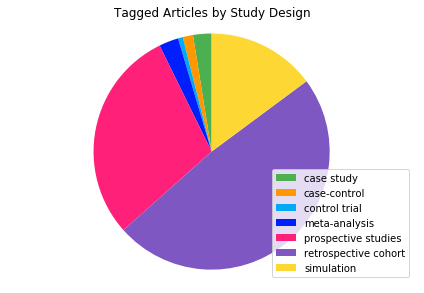

In [12]:
# Connect to database
db = sqlite3.connect("cord19q/articles.sqlite")

articles = pd.read_sql_query('select count(*) as count, case when design=1 then "meta-analysis" when design in (2, 3) then "control trial" ' + 
                             'when design in (4, 5, 6) then "prospective studies" when design=7 then "retrospective cohort" ' +
                             'when design in (8, 9) then "case-control" when design=10 then "case study" else "simulation" end as design from articles ' +
                             'where tags is not null and design > 0 group by design', db)

articles = articles.groupby(["design"]).sum().reset_index()

# Plot a pie chart of study types
pie(articles["design"], articles["count"], "Tagged Articles by Study Design")


## Exploration Takeaways
Given the urgency to find any data to help, many of the tagged articles are recent. Publications by nature put hypothesises and theories through a rigorious scientific method/peer review to ensure accuracy and reliability. It's a balancing act of not holding on to data that can help against making sure decisions are based on accurate data. Given that all searches are against this subset of data, conclusions should be carefully drawn. 

# Testing the model

Now that both the articles.sqlite database and embeddings index are both created, lets test that everything is working properly.

## Word Embeddings
The foundation of sentence embeddings are word embeddings. As previously explained, sentence embeddings are just word embeddings joined together (each token weighted by a BM25 index). 

In [13]:
from cord19q.embeddings import Embeddings

embeddings = Embeddings()
embeddings.load("cord19q")

vectors = embeddings.vectors

pd.DataFrame(embeddings.vectors.most_similar("covid-19", topn=10), columns=["key", "value"])


,key,value
0,ncovid-19,0.935886
1,covid--19,0.919362
2,covid-10,0.895873
3,alg-covid-19,0.887399
4,covid-9,0.875180
5,vovid-19,0.874619
6,non-covid-19,0.855722
7,covid-19related,0.841528
8,pre-covid-19,0.839932
9,covid-19-like,0.839020


The vector model is good at identifying near matches, which helps increase the accuracy of the overall model. Notice that the top hits are typos (covid-10 mistyped 0 instead of 9). 

Below shows similarity for a list of terms, numbers look overall as expected, model has learned an association between the various diseases and knows phone is not related.

In [14]:
vectors.similarity("coronavirus", ["sars", "influenza", "ebola", "phone"])

[0.64188856, 0.4630866, 0.40667415, 0.16214265]

## Sentence Embeddings
At the highest level, the model builds embeddings for each sentence in the corpus. For input queries, it compares each sentence against the input query. Faiss enables that similarity search to be fast. An example of how this works at a small level below.

In [15]:
sentence1 = "Range of incubation periods for the disease in humans"
sentence2 = "The incubation period of 2019-nCoV is generally 3-7 days but no longer than 14 days, and the virus is infective during the incubation period"

embeddings.similarity(Tokenizer.tokenize(sentence1), Tokenizer.tokenize(sentence2))

0.5837459

In [16]:
sentence1 = "Range of incubation periods for the disease in humans"
sentence2 = "The medical profession is short on facemasks during this period, more are needed"

embeddings.similarity(Tokenizer.tokenize(sentence1), Tokenizer.tokenize(sentence2))

0.1722182

## Run a query
Run a full query to ensure model is working.

In [17]:
from cord19q.query import Query

# Execute a test query
Query.run("antiviral covid-19 success treatment", 5, "cord19q")

!! Could not derive your terminal width !!


Loading model from cord19q
Query: antiviral covid-19 success treatment

Highlights
 - All patients received antiviral treatment despite the uncertainty of the efficacy of drugs used.

Articles

Title: 2019-nCoV (Wuhan virus), a novel Coronavirus: Human-to-human transmission, travel-related cases, and vaccine readiness
Published: 2020
Publication: Journal of Infection in Developing Countries
Design: Retrospective Cohort
Severity: None
Sample: [59] On 8 January 2020, it was reported that a novel coronavirus had been sequenced from one patient and subsequently identified in some of the other patients with pneumonia , later reported as 15 of the 59 patients .
Method: Some critical questions include: Do all infected individuals show symptoms?
Id: 7e8409337e69a72191475029805c6776ad43b60b
Reference: https://doi.org/10.3855/jidc.12425
 - (0.6758): The efficacy of a variety of antiviral therapeutics has been investigated for MERS with limited success.

Title: Substrate specificity profiling of 

In [18]:
from cord19q.report import Report
from IPython.display import display, Markdown

transmission = \
    ["Range of incubation periods",
     "Incubation period across different age groups",
     "Incubation period by health condition",
     "How long individuals are contagious, even after recovery.",
     "Prevalence of asymptomatic shedding and transmission (e.g., particularly children).",
     "Seasonality of transmission.",
     "Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).",
     "Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).",
     "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).",
     "Natural history of the virus and shedding of it from an infected person",
     "Implementation of diagnostics and products to improve clinical processes",
     "Disease models, including animal models for infection, disease and transmission",
     "Tools and studies to monitor phenotypic change and potential adaptation of the virus",
     "Immune response and immunity",
     "Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
     "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
     "Role of the environment in transmission"]

risk_factors = \
    ["Hypertension",
     "Diabetes",
     "Heart Disease",
     "Smoking",
     "COPD",
     "Stroke",
     "Cancer",
     "Respiratory disease",
     "Chronic respiratory disease",
     "Kidney disease",
     "Liver disease",
     "Alcohol Abuse",
     "Tuberculosis"]

virus_genome = \
    ["Real-time tracking of whole virus genomes",
     "Mechanism for coordinating the rapid dissemination of that genome information to inform the development of diagnostics and therapeutics",
     "Track variations of the virus over time",
     "Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences",
     "Determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.",
     "Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding)",
     "Evidence that livestock could serve as a reservoir after the epidemic appears to be over.",
     "Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.",
     "Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.",
     "Experimental infections to test host range for this pathogen.",
     "Animal host(s) and any evidence of continued spill-over to humans",
     "Socioeconomic and behavioral risk factors for this spill-over",
     "Sustainable risk reduction strategies"]

interventions = \
    ["Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
     "Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
     "Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
     "Methods to control the spread in communities, barriers to compliance and how these vary among different populations..",
     "Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
     "Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
     "Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
     "Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."]

vaccines = \
    ["Effectiveness of drugs being developed and tried to treat COVID-19 patients.",
     "Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
     "Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.",
     "Exploration of use of best animal models and their predictive value for a human vaccine.",
     "Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
     "Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
     "Efforts targeted at a universal coronavirus vaccine.",
     "Efforts to develop animal models and standardize challenge studies",
     "Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers",
     "Approaches to evaluate risk for enhanced disease after vaccination",
     "Assays to evaluate vaccine immune response and process development for vaccines [in conjunction with therapeutics]",
     "Suitable animal models for vaccine development"]

medical_care = \
    ["Resources to support skilled nursing facilities and long term care facilities.",
     "Mobilization of surge medical staff to address shortages in overwhelmed communities",
     "Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
     "Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients",
     "Outcomes data for COVID-19 after mechanical ventilation adjusted for age.",
     "Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.",
     "Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.",
     "Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.",
     "Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.",
     "Guidance on the simple things people can do at home to take care of sick people and manage disease.",
     "Oral medications that might potentially work.",
     "Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.",
     "Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.",
     "Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials",
     "Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials",
     "Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)"]

sharing = \
    ["Methods for coordinating data-gathering with standardized nomenclature.",
     "Sharing response information among planners, providers, and others.",
     "Understanding and mitigating barriers to information-sharing.",
     "How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).",
     "Integration of federal/state/local public health surveillance systems.",
     "Value of investments in baseline public health response infrastructure preparedness",
     "Modes of communicating with target high-risk populations (elderly, health care workers).",
     "Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).",
     "Communication that indicates potential risk of disease to all population groups.",
     "Misunderstanding around containment and mitigation.",
     "Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.",
     "Measures to reach marginalized and disadvantaged populations.",
     "Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.",
     "Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.",
     "Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"]

ethics = \
    ["Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019",
     "Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight",
     "Efforts to support sustained education, access, and capacity building in the area of ethics",
     "Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.",
     "Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control.",
     "Secondary impacts of public health measures (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)",
     "Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients",
     "Identify the immediate physical and psychological health of medical staff that must be addressed.",
     "Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."]

diagnostics = \
    ["How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures.",
     "Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible.",
     "Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples)",
     "Early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).",
     "Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.",
     "Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.",
     "National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).",
     "Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.",
     "Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity.",
     "How surveillance experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).",
     "Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.",
     "Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.",
     "Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.",
     "Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.",
     "Policies and protocols for screening and testing.",
     "Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.",
     "Technology roadmap for diagnostics.",
     "Barriers to developing and scaling up new diagnostic tests (e.g., market forces)",
     "How future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.",
     "New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.",
     "Coupling genomics and diagnostic testing on a large scale.",
     "Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.",
     "Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.",
     "One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."]
   
# Writes queries out to a local file for processing
def queries(file, queries):
    with open(file + ".txt", "w") as output:
        for query in queries:
            output.write("%s\n" % query)

# Builds Markdown and Excel reports
def report(file):
    Report.run(file + ".txt", 50, "md", "cord19q")
    Report.run(file + ".txt", 50, "xlsx", "cord19q")

# Save queries to file
queries("transmission", transmission)
queries("risk-factors", risk_factors)
queries("virus-genome", virus_genome)
queries("interventions", interventions)
queries("vaccines", vaccines)
queries("medical-care", medical_care)
queries("sharing", sharing)
queries("ethics", ethics)
queries("diagnostics", diagnostics)

# Building task reports
Task reports are an aggregation of each question within a task in the challenge. For each question, a query is run and the top articles are returned. For each article, text matches are shown as bulleted points and these are the best matching sentences within the article. The full list of result sentences are also analyzed and run through a [textrank algorithm](https://en.wikipedia.org/wiki/Automatic_summarization#TextRank_and_LexRank). Highlights or top sentences within the results are also shown within the report. 

Important source files to highlight
* Report process -> [report.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/report.py)
* Textrank algorithm to highlight best sentences -> [highlights.py](https://github.com/neuml/cord19q/blob/master/src/python/cord19q/highlights.py)

In [19]:
# Generate report for each task list. 
for name in ["transmission", "risk-factors", "virus-genome", "interventions", "vaccines", "medical-care", "sharing", "ethics", "diagnostics"]:
    report(name)

Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q
Loading model from cord19q


# Render a Markdown report

The following code can be used to render a Markdown file for a task report within a notebook.

```python
from IPython.display import display, Markdown

# Where file is the full-path to the Markdown file (transmission, risk-factors, ...)
file = "transmission.md"

display(Markdown(filename=file))
```

# List of task reports

The following is a list of Notebooks covering each task report. The reports are also available in Excel (links below each Notebook). The Notebook and Excel files both have the same data and formatting.

- [What is known about transmission, incubation, and environmental stability?](https://www.kaggle.com/davidmezzetti/cord-19-transmission-incubation-environment)
  - [XLSX](transmission.xlsx)
- [What do we know about COVID-19 risk factors?](https://www.kaggle.com/davidmezzetti/cord-19-risk-factors)
  - [XLSX](risk-factors.xlsx)
- [What do we know about virus genetics, origin, and evolution?](https://www.kaggle.com/davidmezzetti/cord-19-virus-genetics-origin-and-evolution)
  - [XLSX](virus-genome.xlsx)
- [What do we know about vaccines and therapeutics?](https://www.kaggle.com/davidmezzetti/cord-19-vaccines-and-therapeutics)
  - [XLSX](vaccines.xlsx)
- [What do we know about non-pharmaceutical interventions?](https://www.kaggle.com/davidmezzetti/cord-19-non-pharmaceutical-interventions)
  - [XLSX](interventions.xlsx)
- [What has been published about medical care?](https://www.kaggle.com/davidmezzetti/cord-19-medical-care)
  - [XLSX](medical-care.xlsx)
- [What do we know about diagnostics and surveillance?](https://www.kaggle.com/davidmezzetti/cord-19-diagnostics-and-surveillance)
  - [XLSX](diagnostics.xlsx)
- [What has been published about information sharing and inter-sectoral collaboration?](https://www.kaggle.com/davidmezzetti/cord-19-sharing-and-collaboration)
  - [XLSX](sharing.xlsx)
- [What has been published about ethical and social science considerations?](https://www.kaggle.com/davidmezzetti/cord-19-ethical-and-social-science-considerations)
  - [XLSX](ethics.xlsx)
